In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')#忽略一些警告
#显示所有结果
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 导入数据

In [66]:
train=pd.read_csv("data/train.csv")
test=pd.read_csv("data/test.csv")
train.head()

,时间,小区名,小区房屋出租数量,楼层,总楼层,房屋面积,房屋朝向,居住状态,卧室数量,厅的数量,卫的数量,出租方式,区,位置,地铁线路,地铁站点,距离,装修情况,月租金
0,1,3072,0.128906,2,0.236364,0.008628,东南,NaN,1,1,1,NaN,11.0,118.0,2.0,40.0,0.764167,NaN,5.602716
1,1,3152,0.132812,1,0.381818,0.017046,东,NaN,1,0,0,NaN,10.0,100.0,4.0,58.0,0.709167,NaN,16.977929
2,1,5575,0.042969,0,0.290909,0.010593,东南,NaN,2,1,2,NaN,12.0,130.0,5.0,37.0,0.572500,NaN,8.998302
3,1,3103,0.085938,2,0.581818,0.019199,南,NaN,3,2,2,NaN,7.0,90.0,2.0,63.0,0.658333,NaN,5.602716
4,1,5182,0.214844,0,0.545455,0.010427,东北,NaN,2,1,1,NaN,3.0,31.0,NaN,NaN,NaN,NaN,7.300509


In [67]:
train.shape

(196539, 19)

In [68]:
# train["出租方式"].value_counts()
# train["装修情况"].value_counts()
train["居住状态"].value_counts()


3.0    17087
1.0     2483
2.0      568
Name: 居住状态, dtype: int64

In [69]:
train.drop_duplicates(['小区名','地铁线路'])[['小区名','地铁线路']].sort_values(by='小区名')

,小区名,地铁线路
107337,0,3.0
3620,1,3.0
41286,2,5.0
8211,4,NaN
55962,5,NaN
...,...,...
45347,6625,NaN
6622,6626,5.0
1513,6626,1.0
1727,6627,NaN


## 设置后面要用的填充量

In [70]:

space_threshold=0.3
dist_value_for_fill=2#为什么是2,因为距离的最大值是1,没有地铁 意味着很远
line_value_for_fill=0
station_value_for_fill=0
area_value_for_fill=train["区"].mode().values[0]
# 拿到每个区的位置众数
position_by_area=train.groupby('区').apply(lambda x:x["位置"].mode())
position_value_for_fill=position_by_area[position_by_area.index==area_value_for_fill].values[0][0]
state_value_for_fill=0#train["居住状态"].mode().values[0]
decration_value_for_fill=-1#train["装修情况"].mode().values[0]
rent_value_for_fill=-1#train["出租方式"].mode().values[0]


In [38]:
#拿到每个小区房屋出租数量的众数
ratio_by_neighbor=train.groupby('小区名').apply(lambda x:x["小区房屋出租数量"].mode())
index=[x[0] for x in ratio_by_neighbor.index]
ratio_by_neighbor.index=index
ratio_by_neighbor=ratio_by_neighbor.to_dict()
ratio_mode=train["小区房屋出租数量"].mode().values[0]


# 缺失值处理
缺失值的处理方式有：

- 删除带有缺失值的特征，最简单也最浪费信息的方式
- 用均值，众数或固定的数等填充，比1好，但仍不够好
- 考虑缺失的含义，把缺失值作为一种信息
- 用未缺失的数据训练模型，预测缺失的数据（分类型变量用分类算法，数值型变量用回归）
- 通过其他特征进行推测出来

思路：
1. 首先利用没有缺失值的小区名以及有值的地铁站点信息，填充区和位置缺失值
2. 利用小区和位置信息填充地铁线路和地铁站点和距离
3. 还没有填充的地铁站点和地铁线路用固定值填充，单独作为一类（即没有地铁），同时对应的距离填充为2（即距离地铁较远）
4. 按照同名小区的小区房屋出租数量的众数来填充小区房屋出租数量

## 缺失值比例

In [71]:
# 缺失值比例
def ratio_of_null():
    train_missing = (train.isnull().sum()/len(train))*100
    train_missing = train_missing.drop(train_missing[train_missing==0].index).sort_values(ascending=False)
    return pd.DataFrame({'缺失百分比':train_missing})
ratio_of_null()

,缺失百分比
装修情况,90.591180
居住状态,89.753688
出租方式,87.671658
距离,53.302907
地铁站点,53.302907
地铁线路,53.302907
小区房屋出租数量,0.509314
位置,0.015773
区,0.015773


## 填充区和位置
根据数据初步分析时的情况可以看出，位置缺失的就是3269这个小区的，所以选择全部丢弃

In [72]:
train=train[train['小区名']!=3269]

In [73]:
ratio_of_null()

,缺失百分比
装修情况,90.591732
居住状态,89.754107
出租方式,87.673275
距离,53.303682
地铁站点,53.303682
地铁线路,53.303682
小区房屋出租数量,0.508885


## 地铁站点，距离 处理
1. 先用每个同名小区名和同位置的地铁线路,地铁站点,距离众数来填充
2. 剩下的地铁站点，距离，地铁线路的缺失值作为一种特征，表示该房屋附近没有地铁

In [92]:
1.#先按照小区名和位置分组，然后获取每组的站点众数
station_by_nb_pos=train[['小区名','位置','地铁站点','距离']].drop_duplicates().dropna().groupby(['小区名','位置'])['地铁站点','距离'].apply(lambda x:np.max(x.mode()))
station_by_nb_pos

地铁站点        距离
小区名  位置                    
0    59.0    57.0  0.478333
1    59.0    57.0  0.563333
2    40.0    33.0  0.971667
11   24.0   103.0  0.914167
12   28.0    69.0  0.633333
...           ...       ...
6625 41.0    88.0  0.931667
6626 86.0    16.0  0.974167
     136.0   16.0  0.974167
6627 86.0    10.0  0.985000
     136.0   10.0  0.985000

[3342 rows x 2 columns]

In [93]:
station_by_nb=train[['小区名','地铁站点','距离']].drop_duplicates().dropna().groupby('小区名')['地铁站点','距离'].apply(lambda x:np.max(x.mode()))
station_by_nb

,地铁站点,距离
小区名,,
0,57.0,0.478333
1,57.0,0.563333
2,33.0,0.971667
11,103.0,0.914167
12,69.0,0.633333
...,...,...
6622,25.0,0.245000
6623,119.0,0.410000
6625,88.0,0.931667


In [84]:
#拿到每个站点对应的线路
lines_by_station=train[['地铁站点','地铁线路']].drop_duplicates().dropna().groupby('地铁站点')['地铁线路'].min()

In [97]:
def fill_stations(line,s_by_np,s_by_n,l_by_s):
    """
    s_by_np:接收station_by_nb_pos
    s_by_n:接收station_by_nb
    l_by_s:接收lines_by_station
    """
    #首先判断line行地铁站点是否缺失
    #注意这里最好用pd.isna,不要用np.isnull
    if not pd.isna(line['地铁站点']):#不是空，就直接返回原行  
        return line
    #如果小区名和位置组合在数据索引中，就查找进行填充
    if (line['小区名'],line['位置']) in s_by_np:
        line['地铁站点']=s_by_np.loc[(line['小区名'],line['位置']),'地铁站点']
        line['距离']=s_by_np.loc[(line['小区名'],line['位置']),'距离']
        line['地铁线路']=l_by_s[line['地铁站点']]
    elif line['小区名'] in s_by_n.index:
        line['地铁站点']=s_by_n.loc[line['小区名'],'地铁站点']#用小区众数填充
        line['距离']=s_by_n.loc[line['小区名'],'距离']
        line['地铁线路']=l_by_s[line['地铁站点']]
    else:#小区名也找不到的情况下  单独作为一类，即没有地铁
        line['地铁站点']=0
        line['距离']=2#距离用2填充
        line['地铁线路']=0
    return line
train=train.apply(fill_stations,s_by_np=station_by_nb_pos,s_by_n=station_by_nb,l_by_s=lines_by_station,axis=1)
ratio_of_null()

,缺失百分比
装修情况,90.591732
居住状态,89.754107
出租方式,87.673275
小区房屋出租数量,0.508885


## 小区房屋出租数量处理
用每个小区的房屋出租数量众数填充

In [105]:
#拿到每个小区房屋出租数量的众数
ratio_by_neighbor=train[['小区名','小区房屋出租数量']].dropna().groupby('小区名').apply(lambda x:np.mean(x["小区房屋出租数量"].mode()))
ratio_by_neighbor

小区名
0       0.007812
1       0.011719
2       0.007812
4       0.017578
5       0.009766
          ...   
6623    0.011719
6624    0.013672
6625    0.011719
6626    0.076172
6627    0.093750
Length: 5535, dtype: float64

In [99]:
#拿到所有小区的“小区房屋出租数量”众数
ratio_mode=train["小区房屋出租数量"].mode().values[0]
ratio_mode

0.01953125

In [106]:
def fill_by_key(x,k,v,values,mode):
    if not pd.isna(x[v]):
        return x
    else:
        if x[k] in values.index:
            x[v]=values[x[k]]
        else:
            x[v]=mode
        return x
# train['小区房屋出租数量']=train['小区房屋出租数量'].map()
train=train.apply(fill_by_key,k="小区名",v="小区房屋出租数量",values=ratio_by_neighbor,mode=ratio_mode,axis=1)

In [107]:
ratio_of_null()

,缺失百分比
装修情况,90.591732
居住状态,89.754107
出租方式,87.673275


## 装修，居住状态，出租方式--作为单独一类

In [108]:
train["出租方式"]=train["出租方式"].fillna(int(-1))
train["装修情况"]=train["装修情况"].fillna(int(-1))
train["居住状态"]=train["居住状态"].fillna(int(0))

In [109]:
ratio_of_null()

,缺失百分比


# 清除异常样本
针对房屋面集存在的异常值，去掉房屋面积异常的样本

In [110]:
train=train[train['房屋面积']<space_threshold]
train.shape

(196499, 19)

# 纠偏
针对目标值月租金普遍分布过散，进行对数平滑

In [111]:
train["log_rent"] = np.log1p(train["月租金"])#np.log1p  log(1+x)   inf

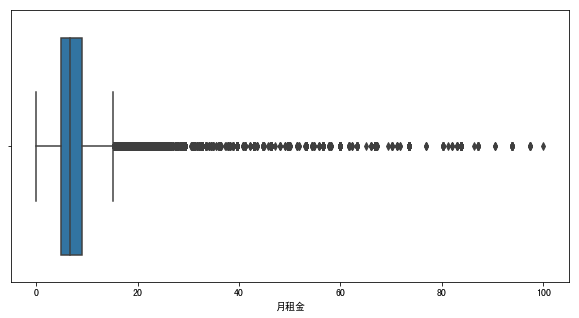

In [112]:
#纠正之前
plt.figure(figsize=(10,5))
sns.boxplot(x="月租金",data=train,orient='h')
plt.show()


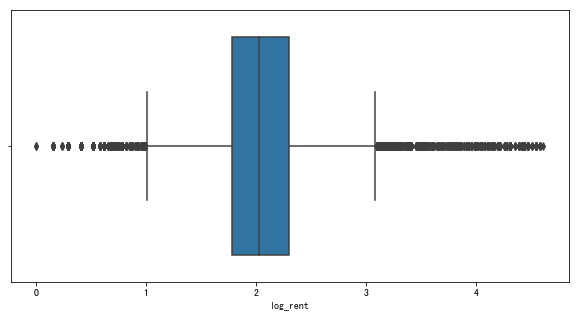

In [113]:
#纠正之后
plt.figure(figsize=(10,5))
sns.boxplot(x="log_rent",data=train,orient='h')
plt.show()

In [114]:
train.head()

,时间,小区名,小区房屋出租数量,楼层,总楼层,房屋面积,房屋朝向,居住状态,卧室数量,厅的数量,卫的数量,出租方式,区,位置,地铁线路,地铁站点,距离,装修情况,月租金,log_rent
0,1,3072,0.128906,2,0.236364,0.008628,东南,0.0,1,1,1,-1.0,11.0,118.0,2.0,40.0,0.764167,-1.0,5.602716,1.887481
1,1,3152,0.132812,1,0.381818,0.017046,东,0.0,1,0,0,-1.0,10.0,100.0,4.0,58.0,0.709167,-1.0,16.977929,2.889145
2,1,5575,0.042969,0,0.290909,0.010593,东南,0.0,2,1,2,-1.0,12.0,130.0,5.0,37.0,0.572500,-1.0,8.998302,2.302415
3,1,3103,0.085938,2,0.581818,0.019199,南,0.0,3,2,2,-1.0,7.0,90.0,2.0,63.0,0.658333,-1.0,5.602716,1.887481
4,1,5182,0.214844,0,0.545455,0.010427,东北,0.0,2,1,1,-1.0,3.0,31.0,0.0,0.0,2.000000,-1.0,7.300509,2.116317


# 问题数据处理
房间朝向列有多个值,这里我们只要第一个

In [115]:
def split(text,i):
    items=text.split(" ")
    if i<len(items):
        return items[i]
    else:
        return np.nan
train['新朝向']=train['房屋朝向'].map(lambda x:split(x,0))

In [116]:
train.head()
train['新朝向'].value_counts()

南     59605
东南    55854
东     34282
西南    17750
北     10490
西      9972
西北     5259
东北     3287
Name: 新朝向, dtype: int64

# 存储数据

In [117]:
train.to_csv("data/train_etl.csv",index=None)

In [30]:
import pickle
time_for_fill=train_data['时间'].mode().values[0]
neighbor_for_fill=train_data['小区名'].mode().values[0]
ting_for_fill=train_data['厅的数量'].mode().values[0]
wei_for_fill=train_data['卫的数量'].mode().values[0]
bed_for_fill=train_data['卧室数量'].mode().values[0]
direction_for_fill=train_data['新朝向'].mode().values[0]
mianji_for_fill=train_data['房屋面积'].mean()
louceng_for_fill=train_data['楼层'].mode().values[0]
zonglouceng_for_fill=train_data['总楼层'].mode().values[0]
values={
    '距离':dist_value_for_fill,
    '地铁线路':line_value_for_fill,
    '地铁站点':station_value_for_fill,
    '区':area_value_for_fill,
    '位置':position_value_for_fill,
    '居住状态':state_value_for_fill,
    '装修情况':decration_value_for_fill,
    '出租方式':rent_value_for_fill,
    'ratio_by_neighbor':ratio_by_neighbor,
    '小区房屋出租数量':ratio_mode,
    '时间':time_for_fill,
    '小区名':neighbor_for_fill,
    '厅的数量':ting_for_fill,
    '卫的数量':wei_for_fill,
    '卧室数量':bed_for_fill,
    '新朝向':direction_for_fill,
    '房屋面积':mianji_for_fill,
    '楼层':louceng_for_fill,
    '总楼层':zonglouceng_for_fill,
    '所有朝向':list(np.unique(train_data['新朝向']))
    
}
with open("data/values.pkl",'wb') as f:
    pickle.dump(values,f)

In [31]:
values

{'距离': 2,
 '地铁线路': 0,
 '地铁站点': 0,
 '区': 12.0,
 '位置': 52.0,
 '居住状态': 0,
 '装修情况': -1,
 '出租方式': -1,
 'ratio_by_neighbor': {0: 0.0078125,
  1: 0.01171875,
  2: 0.0078125,
  4: 0.01953125,
  5: 0.01171875,
  8: 0.0078125,
  9: 0.0234375,
  10: 0.0078125,
  11: 0.03515625,
  12: 0.01953125,
  14: 0.03515625,
  15: 0.1484375,
  16: 0.01953125,
  17: 0.33984375,
  18: 0.046875,
  19: 0.02734375,
  20: 0.03515625,
  22: 0.04296875,
  23: 0.015625,
  24: 0.03125,
  25: 0.32421875,
  26: 0.0078125,
  27: 0.01171875,
  28: 0.01171875,
  29: 0.0078125,
  30: 0.03125,
  31: 0.01171875,
  32: 0.01171875,
  33: 0.0078125,
  34: 0.01171875,
  35: 0.015625,
  36: 0.0078125,
  37: 0.0078125,
  38: 0.0078125,
  39: 0.0078125,
  40: 0.0078125,
  43: 0.01171875,
  44: 0.01171875,
  48: 0.01171875,
  49: 0.01953125,
  50: 0.03125,
  51: 0.015625,
  52: 0.0078125,
  53: 0.0078125,
  54: 0.01171875,
  55: 0.0078125,
  56: 0.0078125,
  57: 0.01953125,
  58: 0.0078125,
  59: 0.01171875,
  60: 0.0078125,
  61: 0.